# Libraries

##  Remove warnings

In [32]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [33]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble      import RandomForestRegressor

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [34]:
# Parameters
#
filename   = 'metadata/6-kanal-2.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [35]:
Lag        =   12
Horizon    =   6

# Data handling

## Import data


In [36]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.07 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-01-29 00:00:06,25.4,17.0,1.2,1.7,214.0,298.0
1,2022-01-29 00:00:21,25.4,17.0,1.2,2.0,213.0,299.0
2,2022-01-29 00:00:41,25.3,17.0,1.2,1.4,214.0,299.0


## Preprocess data

### Set index

In [37]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-01-29 00:00:00,1.227778
2022-01-29 00:05:00,1.833333
2022-01-29 00:10:00,1.626316


In [38]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [39]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

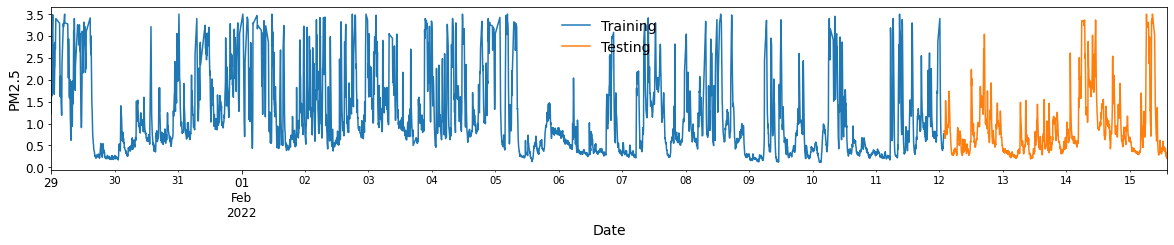

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [41]:
df_test = pd.concat([df_train.iloc[-Lag-Horizon:], df_test])

## Preprocessing

## Data Transformation

In [42]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
        
    df_train = np.log( df_train )
    df_test  = np.log( df_test  )   
    
else:
    print('[INFO] No data transformation applied.')    

[INFO] Data transformation applied


In [43]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [44]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    
    dataX, dataY = [], []
    for idx in tqdm( range(0, df.shape[0] + 1  - Lag-Horizon - Horizon, overlap) ):
        
        data = df[ targetSeries ][idx:idx+Lag+Horizon].copy()
        
        Instances = []
        for i in range(1, Horizon+1):
            Instance  = data.diff(i)[-Lag:].to_list()
            Instance += [ df[ targetSeries ][idx+Lag+Horizon-1] ]
                        
            Instances += [ np.asarray(Instance) ]
            
        dataX.append( Instances )
        
       
    
    
        # Target Instance
        Instance = (df[ targetSeries ].to_numpy()[idx + Lag+Horizon : idx + Lag+Horizon + Horizon] - df[ targetSeries ][idx+Lag+Horizon-1] )

        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY) )

In [45]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Lag // 2)
                               

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 169/169 [00:00<00:00, 925.21it/s]

Training instances:      672
Testing instances:       169


# Forecasting model: RF

## Training process

In [46]:
# Start clock
#
start = time.time()


models = dict()
for i in range( Horizon ):
    from sklearn.ensemble import ExtraTreesRegressor
    model = ExtraTreesRegressor(n_jobs=-1, random_state=42)
#     model = RandomForestRegressor(n_jobs = -1, random_state = 42)
    
    # Train model
    #
    model.fit(trainX[:,i,:-1], trainY[:,i])
    
    models['{}'.format(i+1)] = model
    print('Horizon: {} - Model trained'.format(i+1))
    

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

Horizon: 1 - Model trained
Horizon: 2 - Model trained
Horizon: 3 - Model trained
Horizon: 4 - Model trained
Horizon: 5 - Model trained
Horizon: 6 - Model trained
[INFO] Time 0.81


## Evaluation

### Get predictions

In [47]:
# Start clock
#
start = time.time()

pred = []
for i in range( Horizon ):

    # Get predictions
    #
    pred += [ models['{}'.format(i+1)].predict( testX[:,i,:-1] ) ]

pred = np.asarray( pred )
pred = np.swapaxes(pred, 0, 1)

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))


# pred = model.predict(testX[:,:,:-1])



# # Get prediction of each component tree
# #
# predictions = []
# for Tree in model.estimators_:
#     predictions += [ Tree.predict( testX ) ]
    
# predictions = np.array( predictions )

[INFO] Time 0.64


In [48]:
for i in range( Horizon ):
    testY[:, i] += testX[:, i, -1]
    pred[:, i]  += testX[:, i, -1]

### Calculate Performance on Testing set - Prediction visualization


In [49]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()

    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.13 SMAPE: 13.36 R2: 0.90
Horizon:  2 MAE  0.21 SMAPE: 20.59 R2: 0.77
Horizon:  3 MAE  0.28 SMAPE: 27.36 R2: 0.65
Horizon:  4 MAE  0.32 SMAPE: 32.14 R2: 0.59
Horizon:  5 MAE  0.36 SMAPE: 35.57 R2: 0.48
Horizon:  6 MAE  0.38 SMAPE: 38.43 R2: 0.34


### Residual examination

[INFO] Feature:  PM2.5
------------------------------------------------


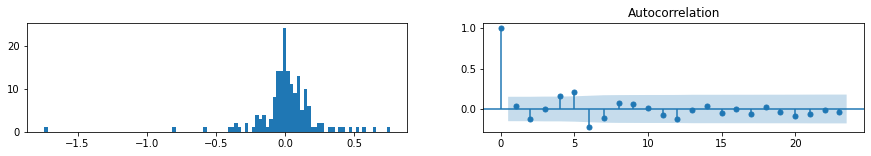

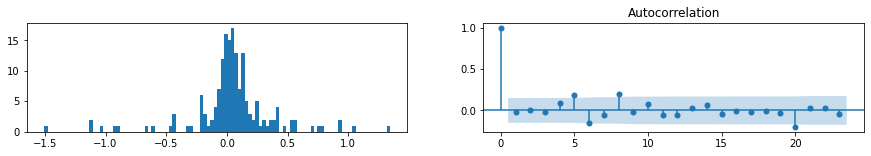

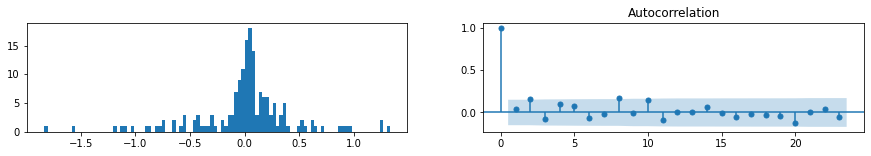

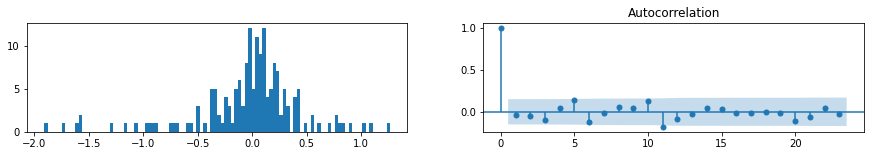

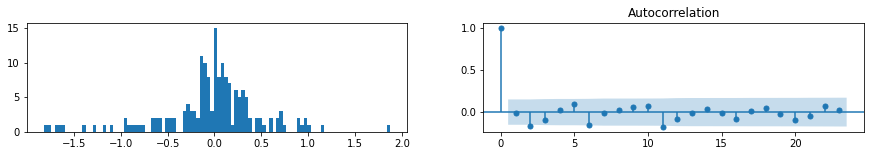

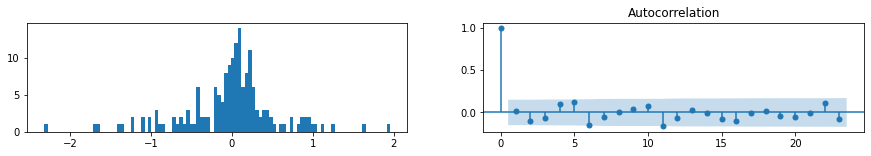

In [50]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices['Prediction'] - Prices['Real']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


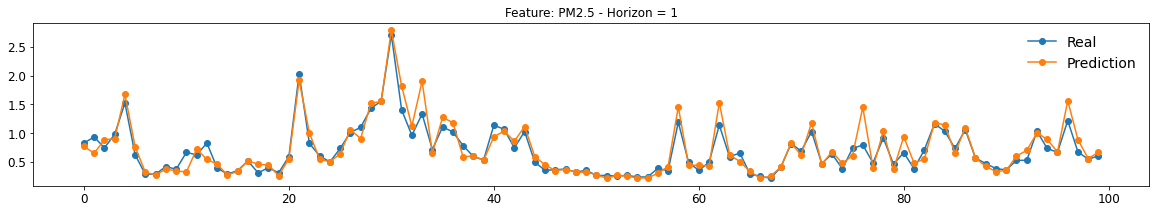

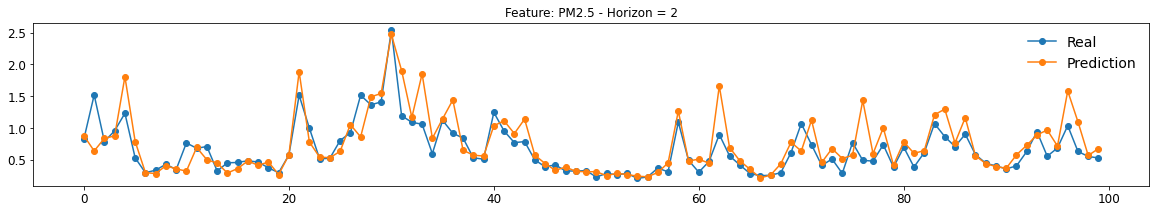

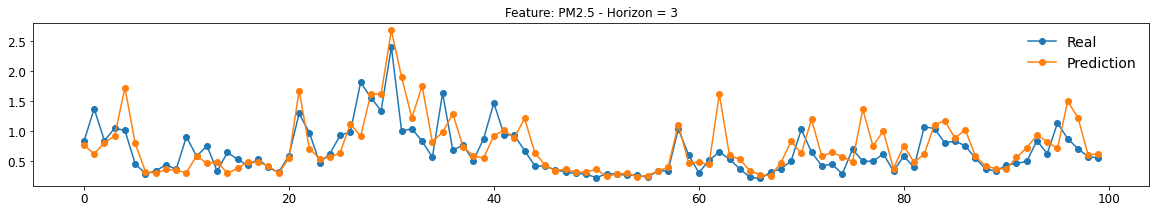

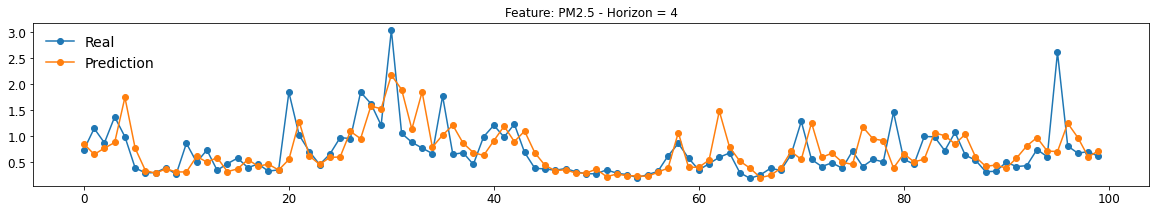

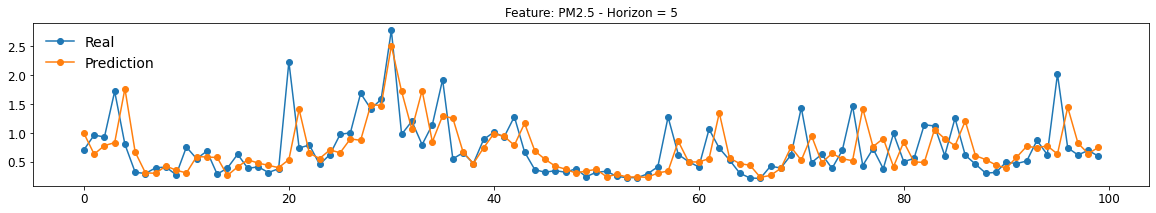

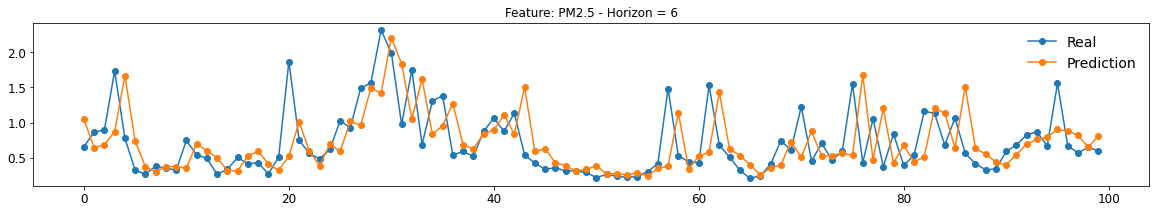

In [51]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = scaler.inverse_transform( testY[:,  i] )
    Prices['Prediction'] = scaler.inverse_transform( pred[:, i]   )



    # Apply inverse transformation   
    #
    if (Transformation == True):
        Prices = np.exp( Prices )
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

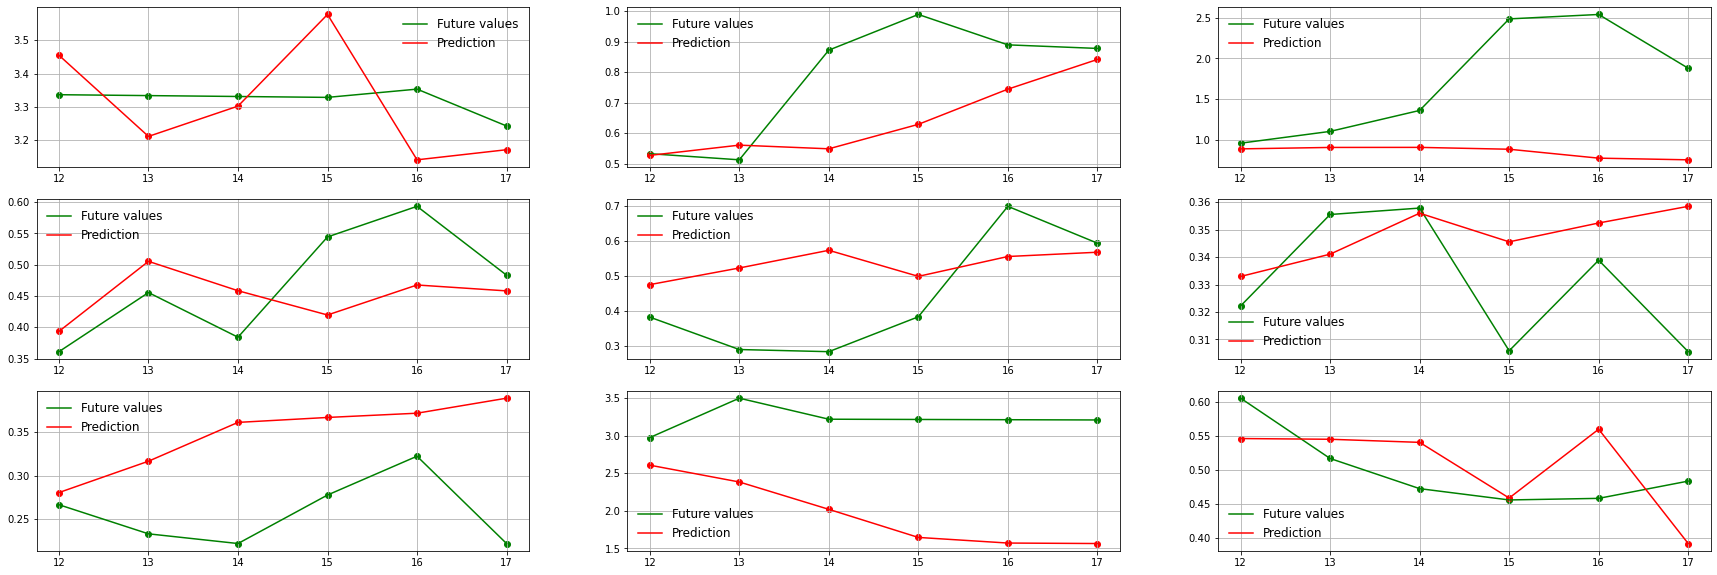

In [52]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (30, 10) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    Real       = scaler.inverse_transform( testY[i] )
    Prediction = scaler.inverse_transform( pred[i]   )

    # Apply inverse transformation   
    #
    if (Transformation == True):
        Real       = np.exp( Real )
        Prediction = np.exp( Prediction )
        
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(Lag, Lag + Horizon), Real, color='g')
    plot_scatter(range(Lag, Lag + Horizon), Prediction, color='r')

    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [53]:
df_test = df[ idx: ]
df_test['RF_NCA'] = pred.flatten()

df_test.to_csv('Predictions/RF_NCA.csv')